# Regression modelling

In this notebook we consider two regression models:
1. Linear regression using weather and time features (hour, month, holiday)
2. Linear regression with polynomial features on current measured weather

In both cases we will use the previously trained linear regression model to forecast the next 24h of net energy usage using 24h weather predictions

Finally, we will do some feature engineering by categorizing the hour into time of the day (morning, afternoon, evening, night) and months into seasons (spring, summer, autumn, winter).

We will use regression to predict the net energy usage for a single building and for the whole collection of 9 buildings.

### Importing packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm

from green_city.regression import plot_ts, error_metrics, train_test_time_split, forecast_dates
from green_city.utils import span, index2datetime
from green_city.plotting import plot_decomposition
from green_city.mlflow_config import get_mlflow_config

import warnings
warnings.filterwarnings('ignore')

RSEED = 42

In [499]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
building_nr = "all"
column_to_predict = "net_load_kW"

#document wide parameters that don't change in experiments
#for logging to mlflow server
global_params = {
    "building_nr": building_nr,
    "predicted_feature": column_to_predict,
    "resolution": "daily",
}

In [4]:
# Set write_date to True for logging to mlflow and SQL database
write_data = False

if write_data:
    
    # ## MLFLOW ##
    try:
        import mlflow
        from green_city.mlflow_config import get_mlflow_config

        flow_conf = get_mlflow_config()
        tracking_uri = flow_conf["TRACKING_URI"]
        mlflow.set_tracking_uri(flow_conf["TRACKING_URI"])
        mlflow.set_experiment(flow_conf["EXPERIMENT_NAME"]);
    except:
        print("mlflow ui not active")


    # ## DB CONNECTION ##
    from sqlalchemy import create_engine
    from decouple import Config, RepositoryEnv

    config = Config(RepositoryEnv("../.db_credentials"))
    db_connection_credentials = {
        "database": config('POSTGRES_DB'),
        "user": config('POSTGRES_USER'),
        "password": config('POSTGRES_PASSWORD'),
        "host": config('POSTGRES_HOST'),
        "port": config('POSTGRES_PORT'),
    }
    DB_STRING = "postgresql://{user}:{password}@{host}:{port}/{database}".format(**db_connection_credentials)
    db = create_engine(DB_STRING)

### Load data

In [5]:
# Load data
if building_nr == 'all':
    df = pd.read_csv(f"../data/preprocessed/Agg_buildings.csv").astype({'datetime': 'datetime64'}).set_index('datetime')
else:
    df = pd.read_csv(f"../data/preprocessed/Building_{building_nr}.csv").astype({'datetime': 'datetime64'}).set_index('datetime')
df.fillna(0.0, inplace=True)

In [12]:
# Extra columns for time features
df['hour'] = df.index.hour
df['month'] = df.index.month
df['year'] = df.index.year
df['day_of_week'] = df.index.day_of_week.astype('category')

df['net_load_kW_lag24'] = df['net_load_kW'].shift(24)
df['net_load_kW_lag48'] = df['net_load_kW'].shift(48)
df['net_load_kW_lag168'] = df['net_load_kW'].shift(24*7)

# Shift predicted weather values by 24hr
df['pred_24h_diffuse_solar_W_m2_shift'] = df['pred_24h_diffuse_solar_W_m2'].shift(periods=24)
df['pred_24h_direct_solar_W_m2_shift'] = df['pred_24h_direct_solar_W_m2'].shift(periods=24)
df['pred_24h_outdoor_temp_shift'] = df['pred_24h_outdoor_temp'].shift(periods=24)
df['pred_24h_outdoor_hum_shift'] = df['pred_24h_outdoor_hum'].shift(periods=24)
df = df.dropna()

### Correlation matrix

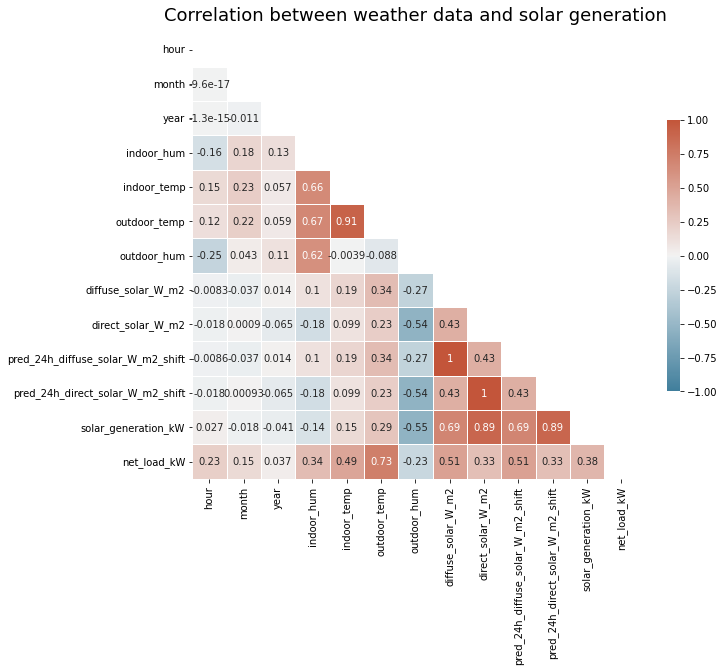

In [7]:
# Correlation matrix
fig, ax = plt.subplots(figsize=(10,10))
corr_weather= df[['hour', 'month', 'year', 'indoor_hum', 'indoor_temp', 
                    'outdoor_temp','outdoor_hum', 'diffuse_solar_W_m2', 
                    'direct_solar_W_m2', 'pred_24h_diffuse_solar_W_m2_shift', 
                    'pred_24h_direct_solar_W_m2_shift', 'solar_generation_kW',
                    'net_load_kW']].corr()
mask = np.triu(np.ones_like(corr_weather, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
heatmap = sns.heatmap(corr_weather, mask=mask, cmap=cmap, vmax=1, vmin=-1, 
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
heatmap.set_title('Correlation between weather data and solar generation', 
                    fontdict={'fontsize':18}, pad=12);


## Regression modelling

### 1. Linear regression model using current weather conditions to predict net energy usage

In [13]:
# Include weather features for linear regression
features = ['outdoor_temp', 'outdoor_hum', 
            'diffuse_solar_W_m2', 'direct_solar_W_m2', 
            'net_load_kW_lag24', 'net_load_kW_lag48', 'net_load_kW_lag168',
            'hour', 'month', 'holiday', 'day_of_week']
dummy_features = ['hour', 'month', 'holiday', 'day_of_week']
target = 'net_load_kW'

# Do train-test split
X_train, y_train, X_test, y_test, df_train, df_test = train_test_time_split(
                                                        df, features, target, 
                                                        dummy_features)

# Fit linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predict for train and test data
y_pred_train = lin_reg.predict(X_train)
y_pred_test = lin_reg.predict(X_test)
df_train['linreg'] = y_pred_train
df_test['linreg'] = y_pred_test

# Calculate and print error metrics
_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Linear regression")                                                      

----------------------------------------
Linear regression
----------------------------------------
R2 (train): 0.903
R2 (test) : 0.836
MAE (test): 46.237
MSE (test): 3989.692
RMSE(test): 63.164


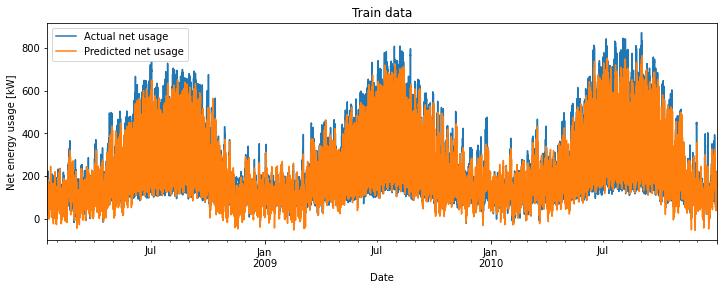

In [14]:
# Plot actual vs predicted train data
plot_ts(df_train['net_load_kW'], df_train['linreg'], "Train data")

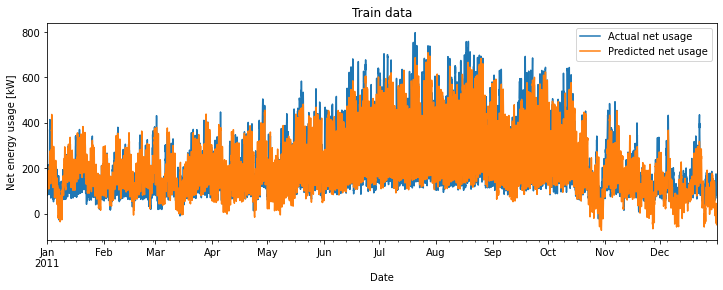

In [15]:
# Plot actual vs predicted train data
plot_ts(df_test['net_load_kW'], df_test['linreg'], "Train data")

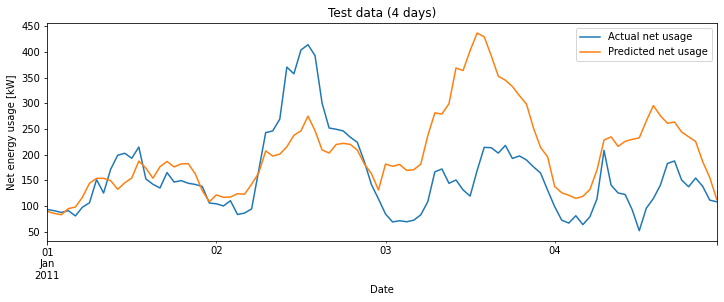

In [16]:
# Plot actual vs predicted train data
plot_ts(df_test['net_load_kW'].iloc[0:24*4], df_test['linreg'].iloc[0:24*4], "Test data (4 days)")

In [19]:
# Use 24h predicted weather features for linear regression
features = ['pred_24h_outdoor_temp_shift', 'pred_24h_outdoor_hum_shift', 
            'pred_24h_diffuse_solar_W_m2_shift', 'pred_24h_direct_solar_W_m2_shift', 
            'net_load_kW_lag24', 'net_load_kW_lag48', 'net_load_kW_lag168',
            'hour', 'month', 'holiday', 'day_of_week']
dummy_features = ['hour', 'month', 'holiday', 'day_of_week']
target = 'net_load_kW'

# Do train-test split
X_train, y_train, X_test, y_test, df_train, df_test = train_test_time_split(
                                                        df, features, target, 
                                                        dummy_features)

# Predict for train and test data
y_pred_train = lin_reg.predict(X_train)
y_pred_test = lin_reg.predict(X_test)
df_train['linreg'] = y_pred_train
df_test['linreg'] = y_pred_test

# Calculate and print error metrics
_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Linear regression")                                                        

----------------------------------------
Linear regression
----------------------------------------
R2 (train): 0.902
R2 (test) : 0.834
MAE (test): 46.555
MSE (test): 4037.613
RMSE(test): 63.542


Day: 2011-09-01 23:00:00, mae: 52.166, mse: 3728.680, rmse: 61.063, r2: 0.816
Day: 2011-10-20 23:00:00, mae: 21.224, mse: 731.104, rmse: 27.039, r2: 0.953
Day: 2011-01-09 06:00:00, mae: 38.613, mse: 1932.121, rmse: 43.956, r2: -0.010
Day: 2011-10-22 21:00:00, mae: 34.050, mse: 1740.623, rmse: 41.721, r2: 0.390
Day: 2011-06-21 03:00:00, mae: 36.124, mse: 1913.050, rmse: 43.738, r2: 0.916
Day: 2011-07-08 02:00:00, mae: 35.349, mse: 2035.195, rmse: 45.113, r2: 0.906
Day: 2011-08-19 00:00:00, mae: 38.397, mse: 4085.449, rmse: 63.918, r2: 0.904
Day: 2011-04-15 07:00:00, mae: 20.994, mse: 720.103, rmse: 26.835, r2: 0.879
Avg mae: 34.615, Avg mse: 2110.791, Avg rmse: 45.943, Avg r2: 0.879


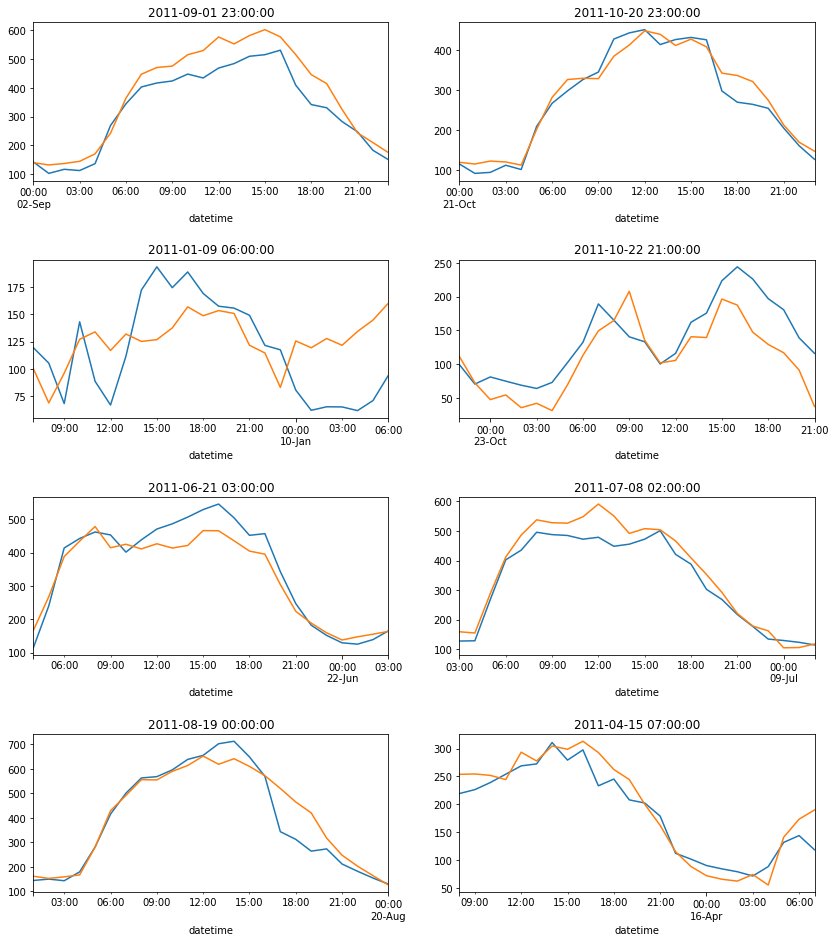

In [20]:
# Forecast for 8 randomly chosen dates
forecast_dates(df_test, "linreg", write_data)

### 2. Multiple linear regression model with 2 polynomial features using current weather conditions

In [21]:
# Include current weather features for linear regression
features = ['outdoor_temp', 'outdoor_hum', 
            'diffuse_solar_W_m2', 'direct_solar_W_m2', 
            'net_load_kW_lag24', 'net_load_kW_lag48', 'net_load_kW_lag168',
            'hour', 'month', 'holiday', 'day_of_week']
dummy_features = ['hour', 'month', 'holiday', 'day_of_week']
target = 'net_load_kW'

# Do train-test split
X_train, y_train, X_test, y_test, df_train, df_test = train_test_time_split(
                                                        df, features, target, 
                                                        dummy_features)

# Scaling features
scaled_features = ['outdoor_temp', 'outdoor_hum', 'diffuse_solar_W_m2', 'direct_solar_W_m2']
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[scaled_features] = scaler.fit_transform(X_train_scaled[scaled_features])
X_test_scaled[scaled_features] = scaler.transform(X_test_scaled[scaled_features])
                                                   

In [22]:
# here we will add the second degree polynomial features
n=2
polynomial_features = PolynomialFeatures(degree=n, include_bias=False)
x_poly_train = polynomial_features.fit_transform(X_train_scaled)   # Transform training data
x_poly_test = polynomial_features.transform(X_test_scaled)         # Transform test data

model_poly = LinearRegression() # Do linear regression
model_poly.fit(x_poly_train, y_train)

# Predict for train and test data
y_pred_test = model_poly.predict(x_poly_test)
y_pred_train = model_poly.predict(x_poly_train)

# Calculate and print error metrics
_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Linear regression with polynomial (n=2)")

----------------------------------------
Linear regression with polynomial (n=2)
----------------------------------------
R2 (train): 0.986
R2 (test) : 0.917
MAE (test): 29.936
MSE (test): 2030.097
RMSE(test): 45.057


### Using previously trained model to forecast net energy usage

In [23]:
# Use 24h predicted weather features for linear regression
features = ['pred_24h_outdoor_temp_shift', 'pred_24h_outdoor_hum_shift', 
            'pred_24h_diffuse_solar_W_m2_shift', 'pred_24h_direct_solar_W_m2_shift', 
            'net_load_kW_lag24', 'net_load_kW_lag48', 'net_load_kW_lag168',
            'hour', 'month', 'holiday', 'day_of_week']
dummy_features = ['hour', 'month', 'holiday', 'day_of_week']
target = 'net_load_kW'

# Do train-test split
X_train, y_train, X_test, y_test, df_train, df_test = train_test_time_split(
                                                        df, features, target, 
                                                        dummy_features)

# Scaling features
scaled_features_fc = ['pred_24h_outdoor_temp_shift', 'pred_24h_outdoor_hum_shift', 
                    'pred_24h_diffuse_solar_W_m2_shift', 'pred_24h_direct_solar_W_m2_shift']
X_train_scaled_fc = X_train
X_test_scaled_fc = X_test
X_train_scaled_fc[scaled_features_fc] = scaler.transform(X_train_scaled_fc[scaled_features_fc])
X_test_scaled_fc[scaled_features_fc] = scaler.transform(X_test_scaled_fc[scaled_features_fc])

In [24]:
# Transform using previous transformation 
x_poly_train_fc = polynomial_features.transform(X_train_scaled_fc) # Transform training x-data
x_poly_test_fc = polynomial_features.transform(X_test_scaled_fc)   # Transform test x-data

# Predict using already trained model
y_pred_train_fc = model_poly.predict(x_poly_train_fc)
y_pred_test_fc = model_poly.predict(x_poly_test_fc)

# Save to DataFrame for plotting
df_train['linreg_poly'] = y_pred_train_fc
df_test['linreg_poly'] = y_pred_test_fc

# Print error metrics
_ = error_metrics(y_train, y_pred_train_fc, y_test, y_pred_test_fc, title="Linear regression with polynomial features using 24h weather forecasts")

----------------------------------------
Linear regression with polynomial features using 24h weather forecasts
----------------------------------------
R2 (train): 0.98
R2 (test) : 0.91
MAE (test): 31.834
MSE (test): 2185.627
RMSE(test): 46.751


In [515]:
# forecasts = df_test[['net_load_kW','linreg_poly','outdoor_temp','outdoor_hum']]
# forecasts["datetime"] = forecasts.index

# filename = '../data/models/linreg_poly_building_'+str(building_nr)+'.pkl'
# forecasts.to_pickle(filename)

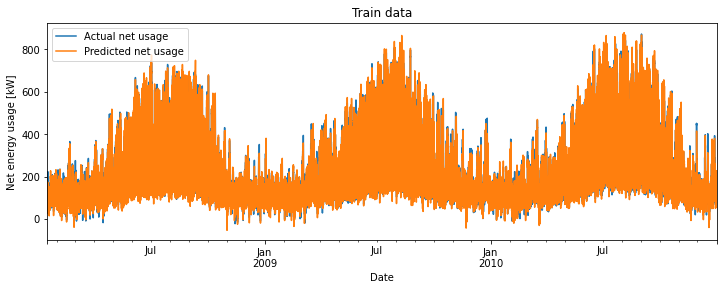

In [25]:
# Plot actual vs predicted train data
plot_ts(df_train['net_load_kW'], df_train['linreg_poly'], "Train data")

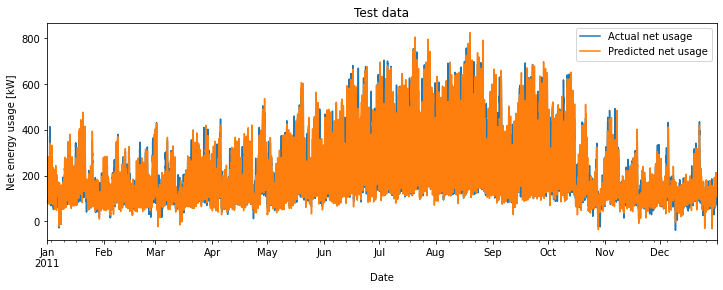

In [26]:
# Plot actual vs predicted test data
plot_ts(df_test['net_load_kW'], df_test['linreg_poly'], "Test data")

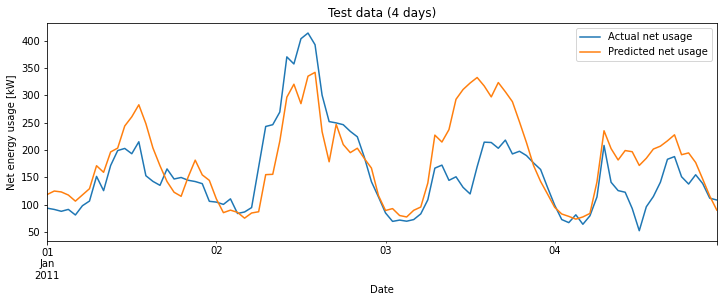

In [27]:
# Plot actual vs predicted test data for 4 days
plot_ts(df_test['net_load_kW'].iloc[0:24*4], df_test['linreg_poly'].iloc[0:24*4], "Test data (4 days)")

Day: 2011-09-01 23:00:00, mae: 52.165, mse: 4388.184, rmse: 66.243, r2: 0.784
Day: 2011-10-20 23:00:00, mae: 36.637, mse: 2158.170, rmse: 46.456, r2: 0.861
Day: 2011-01-09 06:00:00, mae: 19.949, mse: 606.826, rmse: 24.634, r2: 0.683
Day: 2011-10-22 21:00:00, mae: 20.538, mse: 603.005, rmse: 24.556, r2: 0.789
Day: 2011-06-21 03:00:00, mae: 24.192, mse: 925.202, rmse: 30.417, r2: 0.959
Day: 2011-07-08 02:00:00, mae: 39.368, mse: 2250.168, rmse: 47.436, r2: 0.896
Day: 2011-08-19 00:00:00, mae: 31.195, mse: 1787.359, rmse: 42.277, r2: 0.958
Day: 2011-04-15 07:00:00, mae: 42.375, mse: 2965.509, rmse: 54.456, r2: 0.503
Avg mae: 33.302, Avg mse: 1960.553, Avg rmse: 44.278, Avg r2: 0.503


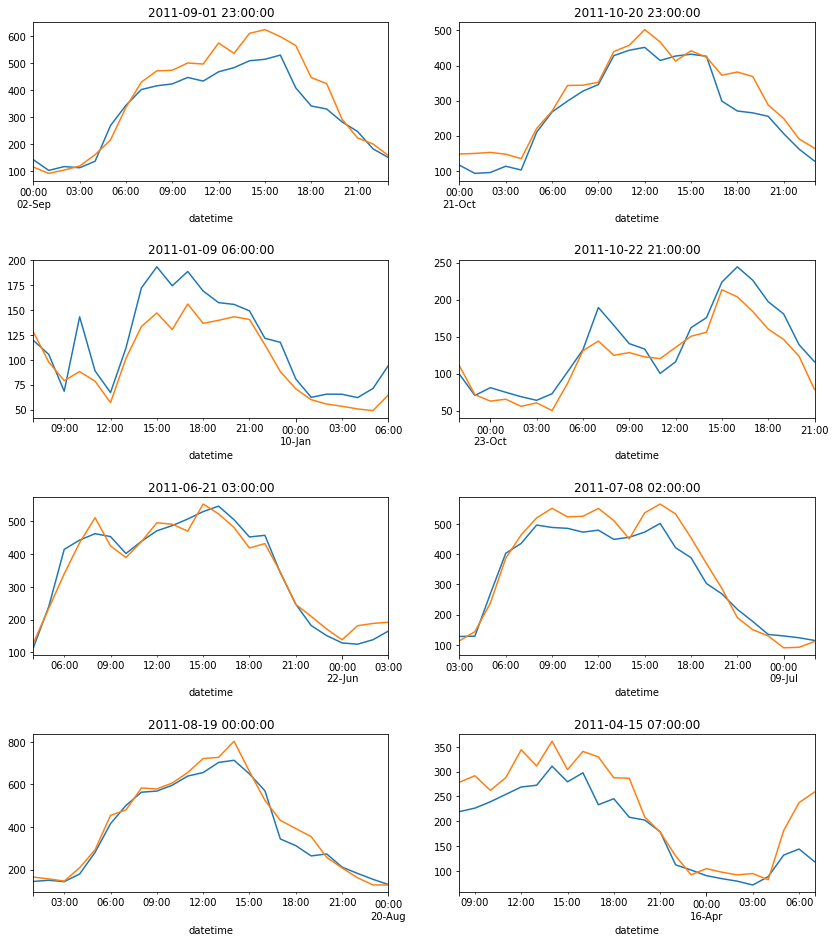

In [519]:
# Forecast for the 8 randomly chosen dates
forecast_dates(df_test, "linreg_poly", write_data)

## Feature engineering

Instead of treating each hour and each month as individual category, we group them since certain hours of the day should have similar energy usage patterns.

In [520]:
# Group months into seasons
def seasons(x):
    if x in [12,1,2]:
        return 'winter'
    elif x in [3,4,5]:
        return 'spring'
    elif x in [6,7,8]:
        return 'summer'
    elif x in [9,10,11]:
        return 'autumn'

# Group hours into morning, afternoon, evening or night
def time_of_day(x):
    if x in [7, 8, 9, 10, 11]:
        return 'morning'
    elif x in [12, 13, 14, 15, 16]:
        return 'afternoon'
    elif x in [17, 18, 19, 20, 21]:
        return 'evening'
    elif x in [22, 23, 0, 1, 2, 3, 4, 5, 6]:
        return 'night'        

In [521]:
df['season'] = df['month'].apply(seasons)
df['season'] = df['season'].astype('category')

df['time_of_day'] = df['hour'].apply(time_of_day)
df['time_of_day'] = df['time_of_day'].astype('category')

df['day_of_week'] = df.index.day_of_week

In [522]:
df_train = df.iloc[:(len(df)-365*24)]   # First 3 years as train data
df_test = df.iloc[(len(df)-365*24):]    # Last year as test data

# Define features and target variables
features = ['outdoor_temp', 'outdoor_hum', 'diffuse_solar_W_m2', 'direct_solar_W_m2', 
            'season', 'time_of_day', 'holiday', 'day_of_week']
target = 'net_load_kW'

X = df[features]
y = df[target]

X['season'] = X['season'].astype('category')
X['time_of_day'] = X['time_of_day'].astype('category')
X['holiday'] = X['holiday'].astype('category')
X['day_of_week'] = X['day_of_week'].astype('category')
X = pd.get_dummies(X, drop_first=True)

# Train and test split 
# First 3 years is the training data
X_train = X[:(len(X)-365*24)]
y_train = y[:(len(y)-365*24)]

# Last year is the test data
X_test = X[(len(X)-365*24):]
y_test = y[(len(y)-365*24):]

# Scaling features
cols_to_scale = ['outdoor_temp', 'outdoor_hum', 'diffuse_solar_W_m2', 'direct_solar_W_m2']
scaler = StandardScaler()
X_train_scaled = X_train
X_test_scaled = X_test
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

In [523]:
# Fit linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Calculate r-squared for train data
y_pred_train = lin_reg.predict(X_train)
df_train['net_load_kW_lin_forecast'] = y_pred_train

# Calculate r-squared for test data
y_pred_test = lin_reg.predict(X_test)
df_test['net_load_kW_lin_forecast'] = y_pred_test

_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Linear regression with feature engineering")

----------------------------------------
Linear regression with feature engineering
----------------------------------------
R2 (train): 0.723
R2 (test) : 0.692
MAE (test): 69.209
MSE (test): 7512.713
RMSE(test): 86.676


In [524]:
# here we will add the second degree polynomial features
n = 2
polynomial_features = PolynomialFeatures(degree=n, include_bias=False)
x_poly_train = polynomial_features.fit_transform(X_train_scaled)   # Transform training x-data
x_poly_test = polynomial_features.transform(X_test_scaled)         # Transform test x-data

model_poly = LinearRegression() # Do linear regression
model_poly.fit(x_poly_train, y_train)
y_pred_test = model_poly.predict(x_poly_test)
y_pred_train = model_poly.predict(x_poly_train)

df_train['net_load_kW_poly_forecast'] = y_pred_train
df_test['net_load_kW_poly_forecast'] = y_pred_test

_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Polynomial linear regression with feature engineering")

----------------------------------------
Polynomial linear regression with feature engineering
----------------------------------------
R2 (train): 0.946
R2 (test) : 0.881
MAE (test): 39.134
MSE (test): 2890.94
RMSE(test): 53.767


Putting the hours of the day and the months of the year into categories does not seem to offer any significant improvement to the net energy usage forecasts.